## ANALYZING AIRCRAFT SAFETY FOR BUSINESS EXPANSION

### Overview

This project aims to identify low-risk aircraft for a company looking to expand into the aviation industry. We'll analyze aviation accident data from 2003 to 2023, focusing on the severity of incidents and the influence of weather conditions and flight purpose. The goal is to provide actionable insights to guide aircraft purchasing decisions and ensure safe operations.

**Data Source**: The NTSB aviation accident database from kaggle(https://www.kaggle.com/datasets/khsamaha/aviation-accident-database-synopses)

###  Data Preparation



In [1]:
#Importing Libraries and loading data
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')     

# Read the CSV file into a DataFrame using latin1 encoding
df = pd.read_csv('C:\\Users\\USER\\Desktop\\DataScience\\data\\AviationData.csv', encoding='latin1')
df.columns


Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

**Key Columns in the Dataset**:

* Event.Id: Unique identifier for each event.

* Investigation.Type: Indicates whether it was an accident or an incident.
* Accident.Number: Unique identifier for the accident.
* Event.Date: Date of the event.
* Location: Location of the event. 
* Country: Country where the event occurred.
* Latitude and Longitude: Coordinates of the event location.
* Airport.Code and Airport.Name: Details about the airport, if applicable. 
* Aircraft.Category: Category of the aircraft involved. 
* Make and Model: Manufacturer and model of the aircraft. 
* Total.Fatal.Injuries, Total.Serious.Injuries, Total.Minor.Injuries, Total.Uninjured: Casualty details. 
* Weather.Condition: Weather condition during the event. 
* Broad.phase.of.flight: Phase of flight during which the event occurred.
* Report.Status: Status of the investigation report. 
* Publication.Date: Date when the report was published.  


In [2]:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

**Summary of the Dataset**:

* Total Records: 88,889 
* Total Columns: 31 
* Missing Values: Many columns contain missing values.Columns like [Latitude, Longitude, Airport.Code, and Airport.Name have a significant amount of missing data. Columns such as Aircraft.Category, FAR.Description, Schedule, Air.carrier, and Broad.phase.of.flight ] also have substantial missing values

### Data Cleaning and Filtering 

In [3]:
# Convert the `Event.Date` column to datetime
df['Event.Date'] = pd.to_datetime(df['Event.Date'])

# Filter data from '2003-01-01' onwards
filtered_df = df[df['Event.Date'] >= '2003-01-01'].copy()

# Create a new column `Fatality_Level` by mapping the values in `Injury.Severity`
severity_mapping = {'Fatal': 'High', 'Non-Fatal': 'Low', 'Incident': 'Low'}
filtered_df['Fatality_Level'] = filtered_df['Injury.Severity'].map(severity_mapping).fillna('Medium')

# Combine the `Make` and `Model` columns to create a new column `Aircraft`
filtered_df['Aircraft'] = filtered_df['Make'] + ' ' + filtered_df['Model']


### Data Analysis 

#### Risk Calculation

**Aggregate Incidents and Severity Levels**

In [4]:
# Group by `Aircraft` and calculate the sum of different types of injuries
incidents_by_aircraft = filtered_df.groupby('Aircraft')[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']].sum()

# Calculate the total number of incidents for each aircraft type
total_incidents_by_aircraft = filtered_df['Aircraft'].value_counts()

# Filter for each severity level and count by aircraft type
high_severity_incidents_by_aircraft = filtered_df[filtered_df['Total.Fatal.Injuries'] > 0]['Aircraft'].value_counts()
medium_severity_incidents_by_aircraft = filtered_df[filtered_df['Total.Serious.Injuries'] > 0]['Aircraft'].value_counts()
low_severity_incidents_by_aircraft = filtered_df[filtered_df['Total.Minor.Injuries'] > 0]['Aircraft'].value_counts()

# Combine total incidents and severity level incidents into a new dataframe
aircraft_incident_summary = pd.concat([total_incidents_by_aircraft, high_severity_incidents_by_aircraft, medium_severity_incidents_by_aircraft, low_severity_incidents_by_aircraft], axis=1).reset_index()
aircraft_incident_summary.columns = ['Aircraft', 'Total_Incidents', 'High_Severity_Incidents', 'Medium_Severity_Incidents', 'Low_Severity_Incidents']
aircraft_incident_summary.fillna(0, inplace=True)


**Calculate Weighted Risk Scores and Filter**

In [5]:
# Calculate the weighted risk score
aircraft_incident_summary['Weighted_Risk_Score'] = (aircraft_incident_summary['High_Severity_Incidents'] * 3) + (aircraft_incident_summary['Medium_Severity_Incidents'] * 2) + aircraft_incident_summary['Low_Severity_Incidents']

# Filter for aircraft with at least 100 total incidents
aircraft_incident_summary_filtered = aircraft_incident_summary[aircraft_incident_summary['Total_Incidents'] >= 100]

# Sort by weighted risk score in ascending order
low_risk_aircraft = aircraft_incident_summary_filtered.sort_values('Weighted_Risk_Score')


#### Aircraft Risk Tier Classification

In [6]:
# Define risk thresholds
low_risk_threshold = aircraft_incident_summary_filtered['Weighted_Risk_Score'].quantile(0.25)
medium_risk_threshold = aircraft_incident_summary_filtered['Weighted_Risk_Score'].quantile(0.50)
high_risk_threshold = aircraft_incident_summary_filtered['Weighted_Risk_Score'].quantile(0.75)

# Assign risk tiers to each aircraft
def assign_risk_tier(score):
    if score <= low_risk_threshold:
        return 'Low'
    elif score <= medium_risk_threshold:
        return 'Medium'
    elif score <= high_risk_threshold:
        return 'High'
    else:
        return 'Very High'

aircraft_incident_summary_filtered['Risk_Tier'] = aircraft_incident_summary_filtered['Weighted_Risk_Score'].apply(assign_risk_tier)

# Print the distribution of risk tiers
print(aircraft_incident_summary_filtered['Risk_Tier'].value_counts().to_markdown(numalign="left", stralign="left"))


|           | Risk_Tier   |
|:----------|:------------|
| Very High | 7           |
| Low       | 7           |
| Medium    | 6           |
| High      | 6           |


### EDA : Basic visualizations

#### Total Incidents vs. Proportion of Incidents in VMC

In [7]:
# Filter the DataFrame to include only rows where `Weather.Condition` is either 'VMC' or 'IMC'
filtered_weather_df = filtered_df[filtered_df['Weather.Condition'].isin(['VMC', 'IMC'])].copy()

# Aggregate incidents by aircraft and weather condition
incidents_by_aircraft_weather = filtered_weather_df.groupby(['Aircraft', 'Weather.Condition']).size().reset_index(name='Incidents')

# Pivot the data to have weather conditions as columns
incidents_by_aircraft_weather_pivot = incidents_by_aircraft_weather.pivot(index='Aircraft', columns='Weather.Condition', values='Incidents').fillna(0)
incidents_by_aircraft_weather_pivot.columns = ['Incidents_VMC', 'Incidents_IMC']

# Merge with the filtered summary DataFrame
merged_df = aircraft_incident_summary_filtered.merge(incidents_by_aircraft_weather_pivot, on='Aircraft', how='left')

# Calculate proportions of VMC and IMC incidents
merged_df['Proportion_VMC'] = merged_df['Incidents_VMC'] / merged_df['Total_Incidents']
merged_df['Proportion_IMC'] = merged_df['Incidents_IMC'] / merged_df['Total_Incidents']



In [8]:
# Scatter plot 1: `Total_Incidents` (x-axis) vs. `Proportion_VMC` (y-axis), colored by `Risk_Tier`
chart1 = alt.Chart(merged_df).mark_circle().encode(
    x=alt.X('Total_Incidents', axis=alt.Axis(title='Total Incidents')),
    y=alt.Y('Proportion_VMC', axis=alt.Axis(title='Proportion of Incidents in VMC')),
    color='Risk_Tier',
    tooltip=['Aircraft', 'Total_Incidents', 'Proportion_VMC', 'Risk_Tier']
).properties(
    title='Total Incidents vs. Proportion of Incidents in VMC (Aircraft with 100+ Incidents)'
).interactive()
chart1


alt.Chart(...)

In [9]:
# Create a scatter plot
chart = alt.Chart(aircraft_incident_summary_filtered).mark_circle().encode(
    x=alt.X('Total_Incidents', axis=alt.Axis(title='Total Incidents')),
    y=alt.Y('Weighted_Risk_Score', axis=alt.Axis(title='Weighted Risk Score')),
    tooltip=['Aircraft', 'Total_Incidents', 'Weighted_Risk_Score']
).properties(
    title='Total Incidents vs. Weighted Risk Score (Aircraft with 100+ Incidents)'
).interactive()
chart
# Save the chart
#chart.save('total_incidents_vs_weighted_risk_score_scatter_plot.json')


alt.Chart(...)

#### Total Incidents vs. Proportion of Incidents in IMC

In [10]:
# Scatter plot 2: `Total_Incidents` (x-axis) vs. `Proportion_IMC` (y-axis), colored by `Risk_Tier`
chart2 = alt.Chart(merged_df).mark_circle().encode(
    x=alt.X('Total_Incidents', axis=alt.Axis(title='Total Incidents')),
    y=alt.Y('Proportion_IMC', axis=alt.Axis(title='Proportion of Incidents in IMC')),
    color='Risk_Tier',
    tooltip=['Aircraft', 'Total_Incidents', 'Proportion_IMC', 'Risk_Tier']
).properties(
    title='Total Incidents vs. Proportion of Incidents in IMC (Aircraft with 100+ Incidents)'
).interactive()
chart2

alt.Chart(...)

#### Top 10 aircraft types with the most incidents

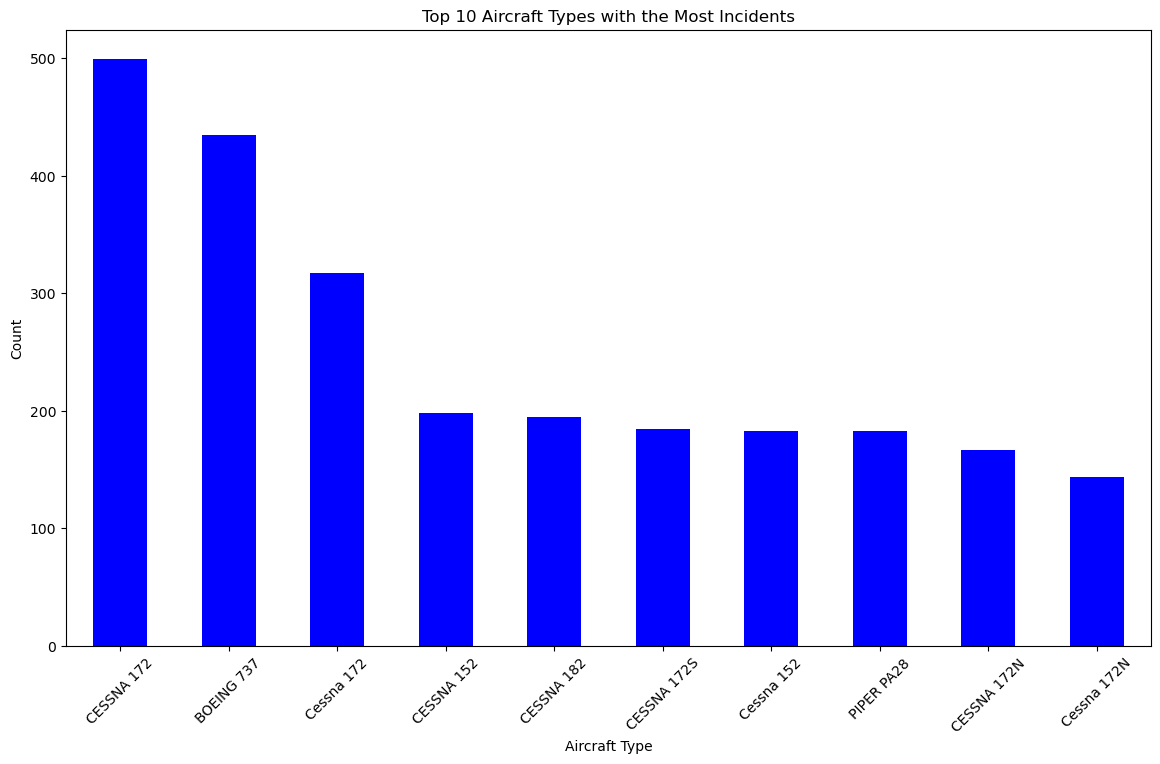

In [11]:
# Top 10 aircraft types with the most incidents
aircraft_count = filtered_df['Aircraft'].value_counts().head(10)

# Plot the top 10 aircraft types
plt.figure(figsize=(14, 8))
aircraft_count.plot(kind='bar', color='blue')
plt.title('Top 10 Aircraft Types with the Most Incidents')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


###  Conclusion 

The analysis reveals that the risk profile of aircraft models is influenced by various factors, including the severity of incidents and weather conditions. While most incidents occur under VMC, some models show a higher proportion of incidents under IMC, highlighting the need for further investigation and potential mitigation strategies. Additionally, the purpose of the flight significantly impacts the risk profile of each aircraft, with personal and instructional flights being the most common purposes associated with incidents for the top 10 lowest risk aircraft.

###  Recommendations 


**Prioritize Low-Risk Aircraft**: Opt for models in the 'Low' risk tier, as they have demonstrated a lower overall risk profile.
Thorough Evaluation of High-Risk Aircraft: If considering models in the 'Very High' risk tier, conduct a comprehensive risk assessment to understand and mitigate potential hazards.

**Regular Risk Assessment**: Implement a continuous risk assessment process for the aircraft fleet, monitoring incident data and adjusting procedures as needed.

**Investigate Weather-Related Incidents**: For models with a higher proportion of incidents under IMC, investigate the underlying causes and implement appropriate measures .